## <a name="C4">0. Importation et fonctions</a>

In [120]:
import warnings
warnings.filterwarnings('ignore')

# Feature engineering
import math
import datetime
import pandas as pd
import numpy as np
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder, OrdinalEncoder, MeanEncoder, DecisionTreeEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.transformation import YeoJohnsonTransformer, ArcsinTransformer, LogTransformer
from feature_engine.outliers import Winsorizer, OutlierTrimmer, ArbitraryOutlierCapper
from feature_engine import selection
from feature_engine.pipeline import Pipeline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from sklearn import feature_selection

# Model
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error, make_scorer, root_mean_squared_log_error, root_mean_squared_error


In [121]:
def get_df_from_array(pipe, X_train, X_test):
    cols = pipe.get_feature_names_out()
    X_train = pd.DataFrame(X_train, columns=cols)
    X_test = pd.DataFrame(X_test, columns=cols)

    return X_train, X_test 

In [122]:
def print_pipeline_results(grid_search):
    results = grid_search.cv_results_
    mean_r2 = results['mean_test_r2']
    mean_rmse = results['mean_test_rmse']
    model_names = []
    for model in results['params']:
        model = model['model']
        model_names.append(type(model).__name__)

    for i in range(len(param_grid)):
        print(f"{model_names[i]} mean R2: {mean_r2[i]} mean RMSE: {mean_rmse[i]}")

## <a name="C4">1. Préparation du dataset</a>

### 1.1 Chargement du dataset

In [123]:
# Load data
df = pd.read_csv('data/clean_dataset.csv')

print(df.shape)

df.head()

(1646, 25)


,Unnamed: 0,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,MissingENERGYSTARScore
0,0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,...,Hotel,88434.0,60.0,7226362.5,2003882.00,3946027.0,1276453.0,249.98,2.83,False
1,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,...,Hotel,83880.0,61.0,8387933.0,0.00,3242851.0,5145082.0,295.86,2.86,False
2,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,...,Hotel,756493.0,43.0,72587024.0,21566554.00,49526664.0,1493800.0,2089.28,2.19,False
3,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,...,Hotel,61320.0,56.0,6794584.0,2214446.25,2768924.0,1811213.0,286.43,4.67,False
4,4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,...,Hotel,123445.0,75.0,14172606.0,0.00,5368607.0,8803998.0,505.01,2.88,False


### 1.2 Création & suppression de variables

Je crée les variables contenant de l'information que j'estime accessible en conditions réelles, évitant la fuite de données.

In [124]:
# Creating energetical mix variables

energy_sources_vars = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

for var in energy_sources_vars:
    var_name = var.replace('(kBtu)', '') + '_share'
    df[var_name] = df[var] / df['SiteEnergyUse(kBtu)']
    print(f'Mean {var_name} : {df[var_name].mean()}')

Mean SteamUse_share : 0.021435099706412226
Mean Electricity_share : inf
Mean NaturalGas_share : inf


In [125]:
# Building age

df['BuildingAge'] = datetime.date.today().year - df['YearBuilt']

Je supprime les variables inutiles, ou qui ne seront pas accessibles à ce modèle en conditions réelles.  
Je garde les variables de consommation d'énergies spécifiques pour l'instant, puisqu'elles me serviront lors de l'étape de création de features.

In [126]:
# Drop unused/unavailable variables
unused_vars = ['Unnamed: 0', 'TotalGHGEmissions', 'GHGEmissionsIntensity'] + energy_sources_vars
df = df.drop(columns=unused_vars)

In [127]:
df = df.loc[df['SiteEnergyUse(kBtu)'] != 0]

### 1.3 Gestion des types de données

Je m'assure que le type de données des variables est bien aligné avec ce que je veux en faire (hors encoding).

In [128]:
df.dtypes

BuildingType                  object
PrimaryPropertyType           object
ZipCode                      float64
CouncilDistrictCode            int64
Neighborhood                  object
Latitude                     float64
Longitude                    float64
YearBuilt                      int64
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFATotal               int64
PropertyGFAParking             int64
PropertyGFABuilding(s)         int64
ListOfAllPropertyUseTypes     object
LargestPropertyUseType        object
LargestPropertyUseTypeGFA    float64
ENERGYSTARScore              float64
SiteEnergyUse(kBtu)          float64
MissingENERGYSTARScore          bool
SteamUse_share               float64
Electricity_share            float64
NaturalGas_share             float64
BuildingAge                    int64
dtype: object

Les variables de zones géographiques n'ayant pas de réel sens quantitatif, je les convertis en variables catégorielles, pour appliquer un Feature Engineering adapté.

In [129]:
num_to_cat_features = ['ZipCode', 'CouncilDistrictCode']
df[num_to_cat_features] = df[num_to_cat_features].astype('object')

Les variables booléennes ne sont pas acceptées par les modèles de ML; je les convertis en format numérique.

In [130]:
bool_to_num_features = ['MissingENERGYSTARScore']
df[bool_to_num_features] = df[bool_to_num_features].astype('object')

In [131]:
df.dtypes

BuildingType                  object
PrimaryPropertyType           object
ZipCode                       object
CouncilDistrictCode           object
Neighborhood                  object
Latitude                     float64
Longitude                    float64
YearBuilt                      int64
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFATotal               int64
PropertyGFAParking             int64
PropertyGFABuilding(s)         int64
ListOfAllPropertyUseTypes     object
LargestPropertyUseType        object
LargestPropertyUseTypeGFA    float64
ENERGYSTARScore              float64
SiteEnergyUse(kBtu)          float64
MissingENERGYSTARScore        object
SteamUse_share               float64
Electricity_share            float64
NaturalGas_share             float64
BuildingAge                    int64
dtype: object

Je peux maintenant catégoriser mes variables pour faciliter les manipulations à venir.

In [132]:
# Feature vs target vars
target_var = 'SiteEnergyUse(kBtu)'
X = df.drop(target_var, axis=1)
y = df[target_var]

In [133]:
# Numerical vs categorical features
num_features = list(X.select_dtypes(include=['int64', 'float64']).columns)
cat_features = list(set(X.columns) - set(num_features))

print("Features numériques:", num_features)
print("Features catégorielles:", cat_features)

Features numériques: ['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SteamUse_share', 'Electricity_share', 'NaturalGas_share', 'BuildingAge']
Features catégorielles: ['ZipCode', 'Neighborhood', 'BuildingType', 'LargestPropertyUseType', 'MissingENERGYSTARScore', 'CouncilDistrictCode', 'ListOfAllPropertyUseTypes', 'PrimaryPropertyType']


In [134]:
# Continuous vs discrete features
discrete_features = ['NumberofFloors', 'NumberofBuildings', 'ENERGYSTARScore', 'YearBuilt', 'BuildingAge']
continuous_features = list(set(num_features) - set(discrete_features))

print("Features continues:", continuous_features)
print("Features discrètes:", discrete_features)

Features continues: ['SteamUse_share', 'PropertyGFAParking', 'Longitude', 'PropertyGFABuilding(s)', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'Electricity_share', 'NaturalGas_share', 'Latitude']
Features discrètes: ['NumberofFloors', 'NumberofBuildings', 'ENERGYSTARScore', 'YearBuilt', 'BuildingAge']


In [135]:
# Proportion vs interval vars
prop_features = [x for x in num_features if 'share' in x]
non_prop_features = list(set(num_features) - set(prop_features))

print("Features proportionnelles:", prop_features)
print("Features non proportionnelles:", non_prop_features)

Features proportionnelles: ['SteamUse_share', 'Electricity_share', 'NaturalGas_share']
Features non proportionnelles: ['PropertyGFAParking', 'NumberofBuildings', 'BuildingAge', 'Longitude', 'PropertyGFABuilding(s)', 'YearBuilt', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'NumberofFloors', 'ENERGYSTARScore', 'Latitude']


### 1.4 Split du jeu de données

Etape obligatoire avant d'apporter des modifications au jeu de données; La séparation en un jeu d'entraînement et un jeu de test.

In [136]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.2,
                                                                    random_state=42
                                                                   )

In [137]:
X_train.shape

(1304, 22)

In [138]:
X_test.shape

(326, 22)

In [139]:
X_train_raw = X_train
y_train_raw = y_train
X_test_raw = X_test
y_test_raw = X_test

## <a name="C4">2. Feature Engineering</a>

### 2.1 Valeurs manquantes

In [140]:
# Missing values
df.isnull().sum()

BuildingType                 0
PrimaryPropertyType          0
ZipCode                      0
CouncilDistrictCode          0
Neighborhood                 0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFATotal             0
PropertyGFAParking           0
PropertyGFABuilding(s)       0
ListOfAllPropertyUseTypes    0
LargestPropertyUseType       0
LargestPropertyUseTypeGFA    0
ENERGYSTARScore              0
SiteEnergyUse(kBtu)          0
MissingENERGYSTARScore       0
SteamUse_share               0
Electricity_share            0
NaturalGas_share             0
BuildingAge                  0
dtype: int64

Peu de valeurs manquantes à traiter. J'appliquerai une simple imputation par la médiane.

### 2.2 Distribution & outliers

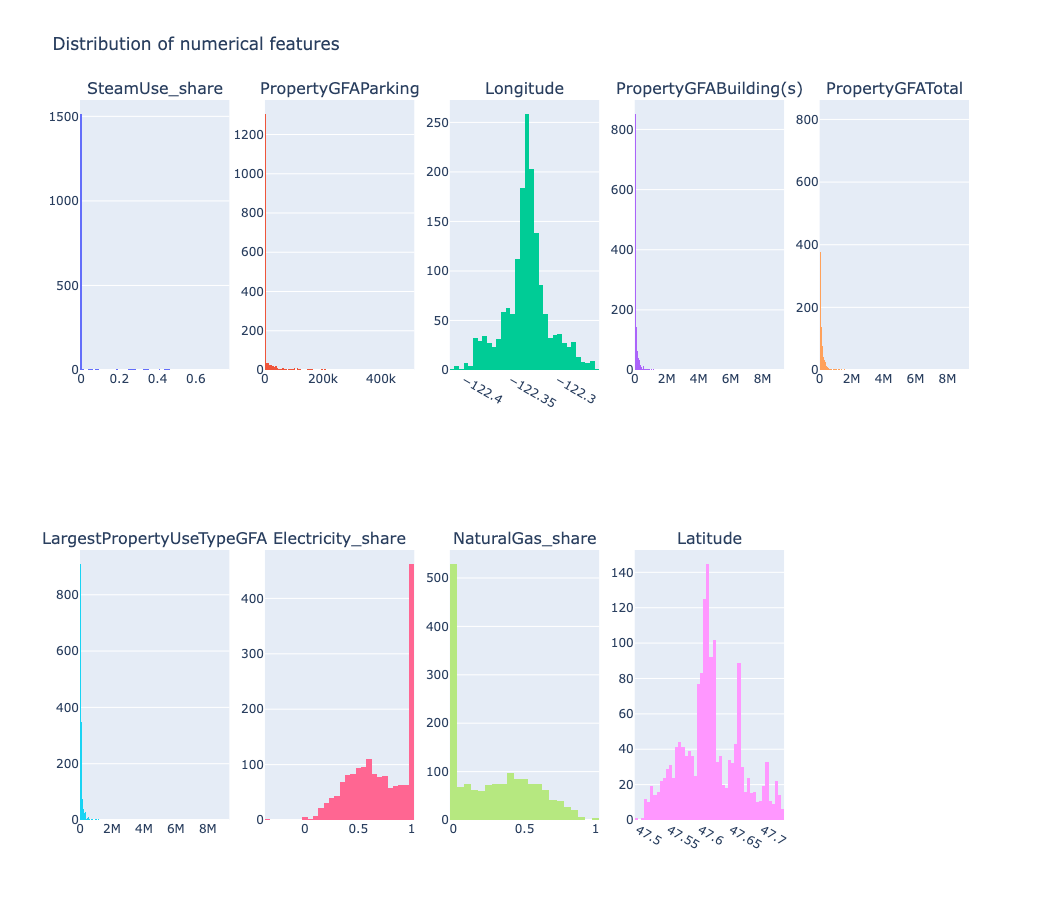

In [141]:
# Distribution of continuous variables

fig = make_subplots(rows=2, cols=5, subplot_titles=continuous_features)

for i, col in enumerate(continuous_features, 1):
    trace = go.Histogram(x=df[col], showlegend=False)
    fig.add_trace(trace, row=(i-1)//5 + 1, col=(i-1)%5 + 1)

fig.update_layout(height=len(continuous_features)*100, title_text="Distribution of numerical features")
fig.show()

In [142]:
skewed_features = ['LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal']

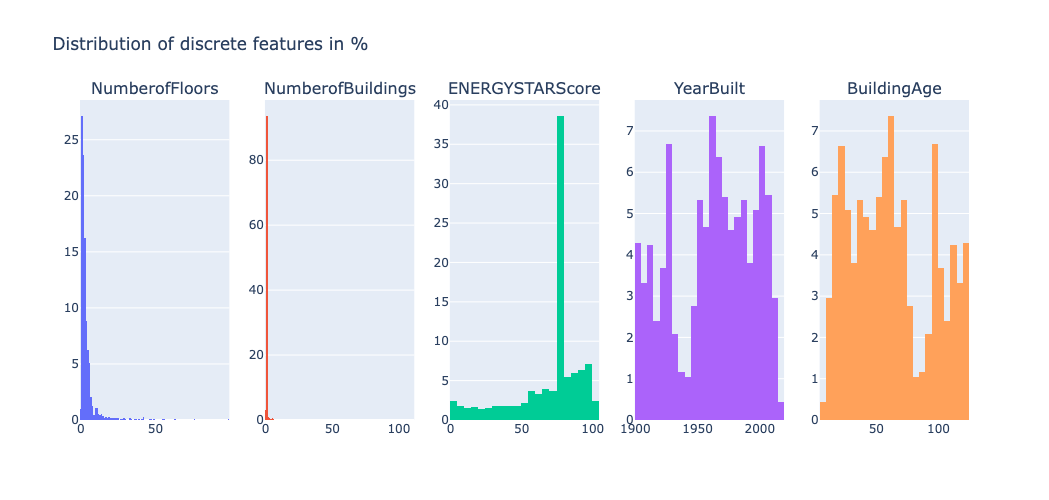

In [143]:
# Distribution of discrete features

fig = make_subplots(rows=1, cols=5, subplot_titles=discrete_features)

for i, col in enumerate(discrete_features, 1):
    trace = go.Histogram(x=df[col], showlegend=False, histnorm='percent')
    fig.add_trace(trace, row=(i-1)//5 + 1, col=(i-1)%5 + 1)

fig.update_layout(height=len(discrete_features)*100, title_text="Distribution of discrete features in %")
fig.show()

In [144]:
skewed_features += ['NumberofFloors', 'NumberofBuildings']

Certaines features numériques ont une distribution très asymétrique, influencée par la présence des gros batîments collectifs identifiés dans l'exploration de données.  
Je vais appliquer des transformations mathématiques pour lisser leurs distributions, voire du capping sur les outliers si ils rendent l'erreur du modèle trop instable.

### 2.3 Cardinalité & labels rares

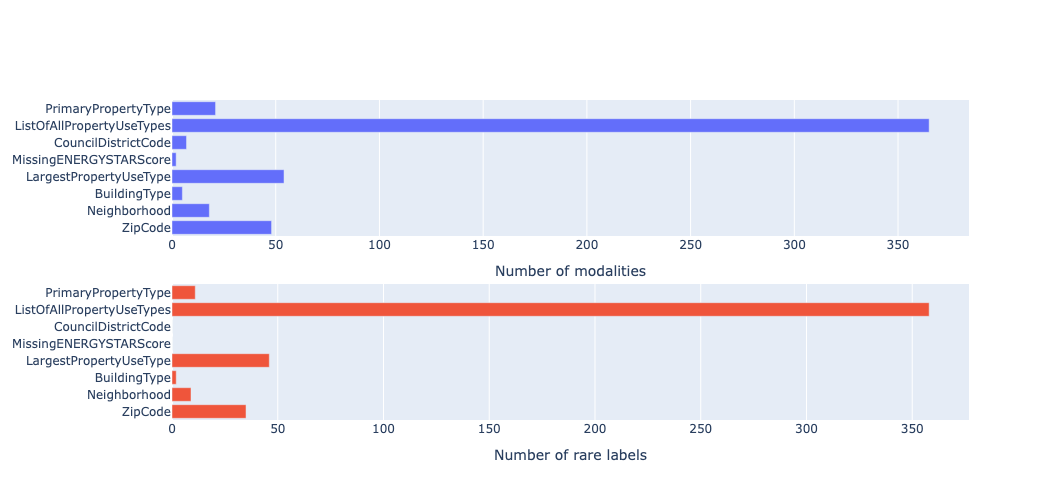

In [145]:
# Cardinality of categorical variables
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Bar(y=cat_features, x=df[cat_features].nunique().values, orientation='h', showlegend=False), row=1, col=1)

rare_labels = []
for var in cat_features:
    value_counts = df[var].value_counts(normalize=True)
    rare_labels.append(len(value_counts[value_counts < 0.03]))
fig.add_trace(go.Bar(x=rare_labels, y=cat_features, orientation='h', showlegend=False), row=2, col=1)

fig.update_xaxes(title_text="Number of modalities", row=1, col=1)
fig.update_xaxes(title_text="Number of rare labels", row=2, col=1)
fig.update_layout(height=500, width=750)

fig.show()

Certaines features catégorielles possèdent une haute cardinalité et de nombreuses modalités peu fréquentes.  
Je vais donc appliquer un regroupement de ces modalités rares, avant de réaliser l'encodage de toutes les features catégorielles.

### 2.4 Transformations indépendentes du modèles

Certaines étapes du Feature engineering sont particuliérement utilisées et performantes sur certains types de modèle.  
Ici, j'applique dans un premier temps les transformations agnostiques du modèle, qui bénéficient à l'ensemble/la majorité des modèles de Machine Learning.

In [146]:
pipe = Pipeline(
    [
        ('imputer_num', MeanMedianImputer(imputation_method='median')),
        ('rare_label_encoding', RareLabelEncoder(variables=cat_features)),
        ('categorical_encoding', OneHotEncoder(variables=cat_features)),
    ]
)

In [147]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer_num', MeanMedianImputer()),
                ('rare_label_encoding',
                 RareLabelEncoder(variables=['ZipCode', 'Neighborhood',
                                             'BuildingType',
                                             'LargestPropertyUseType',
                                             'MissingENERGYSTARScore',
                                             'CouncilDistrictCode',
                                             'ListOfAllPropertyUseTypes',
                                             'PrimaryPropertyType'])),
                ('categorical_encoding',
                 OneHotEncoder(variables=['ZipCode', 'Neighborhood',
                                          'BuildingType',
                                          'LargestPropertyUseType',
                                          'MissingENERGYSTARScore',
                                          'CouncilDistrictCode',
                                          'ListOfAllPropertyUseTypes',
                                          'PrimaryPropertyType']))])

In [148]:
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [149]:
# Transform X_train array back to a DataFrame
X_train, X_test = get_df_from_array(pipe, X_train, X_test)

In [150]:
X_train.shape

(1304, 64)

### 2.5 Sélection de features indépendente du modèle

Dans la même logique, certaines étapes de la sélection de features sont agnostiques du modèle utilisé.

Ici, j'élimine les variables constantes et quasi constantes, puisqu'elles auraient peu de valeur prédictive.

In [151]:
X_train.shape

(1304, 64)

In [152]:
transformer = selection.DropConstantFeatures(tol=0.95)

transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

X_train.shape

(1304, 60)

In [153]:
transformer.features_to_drop_

['BuildingType_Nonresidential COS',
 'BuildingType_Campus',
 'BuildingType_SPS-District K-12',
 'BuildingType_Nonresidential WA']

In [154]:
transformer = selection.DropDuplicateFeatures()

transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

X_train.shape

(1304, 59)

J'ai pu réduire la dimensionalité en supprimant quelques features doublon, ou avec peu de variance, n'altérant pas la qualité de mon modèle.

## <a name="C4">3. Modélisation linéaire</a>

### 3.1 Feature Engineering spécifique

Les modèles linéaires nécéssitent souvent un engineering spécifique, notamment sur:
- **La distribution**, les modèles travaillant sous l'hypothèse de distributions normales et étant sensibles aux outliers
- **La magnitude**, pour ne pas biaiser le poids de chaque prédicteur

In [155]:
X_train_lin = X_train
y_train_lin = y_train

In [156]:
# tf = YeoJohnsonTransformer(variables='SiteEnergyUse(kBtu)')
# y_train_lin = pd.DataFrame(y_train_lin)
# y_test_lin = pd.DataFrame(y_test)
# tf.fit(y_train_lin)
# y_train_lin = tf.transform(y_train_lin)
# y_test_lin = tf.transform(y_test_lin)

In [157]:
pipe = Pipeline(
    [
        ('outlier trimming', OutlierTrimmer(variables=skewed_features, capping_method='gaussian', fold=1)),
        # ('distribution_transformation', YeoJohnsonTransformer(variables=num_features)),
        ('scaler', preprocessing.StandardScaler())
    ]
)

In [158]:
pipe.fit(X_train_lin, y_train_lin)

Pipeline(steps=[('outlier trimming',
                 OutlierTrimmer(fold=1,
                                variables=['LargestPropertyUseTypeGFA',
                                           'PropertyGFABuilding(s)',
                                           'PropertyGFAParking',
                                           'PropertyGFATotal', 'NumberofFloors',
                                           'NumberofBuildings'])),
                ('scaler', StandardScaler())])

In [159]:
# X_train_lin  = pipe.transform(X_train_lin)
# X_test_lin = pipe.transform(X_test)
X_train_lin, y_train_lin = pipe.transform_x_y(X_train, y_train)
X_test_lin, y_test_lin = pipe.transform_x_y(X_test, y_test)

In [160]:
# Transform X_train array back to a DataFrame
X_train_lin, X_test_lin = get_df_from_array(pipe, X_train_lin, X_test_lin)

In [161]:
X_train_lin.shape

(1131, 59)

### 3.2 Sélection et importance des features

Je filtre ensuite les variables trop corrélées entre elles, pour éviter un problème de multicollinéarité et réduire la dimensionalité.

In [162]:
transformer = selection.SmartCorrelatedSelection(method='pearson',
                                                 threshold=0.99,
                                                 selection_method="model_performance", 
                                                 estimator=LinearRegression(),
                                                 cv=3)

In [163]:
transformer.fit(X_train_lin, y_train_lin)
X_train_lin = transformer.transform(X_train_lin)
X_test_lin = transformer.transform(X_test_lin)
X_train_lin.shape

(1131, 57)

In [164]:
transformer.correlated_feature_sets_

[{'BuildingAge', 'YearBuilt'},
 {'MissingENERGYSTARScore_False', 'MissingENERGYSTARScore_True'}]

In [165]:
transformer.features_to_drop_

['BuildingAge', 'MissingENERGYSTARScore_True']

J'ai pu supprimer les features extrêmement corrélées (principalement des features binaires).

Je peux maintenant utiliser le mécanisme de régularisation de la régression Lasso pour garder les features les plus importantes.  
Pour cela, j'effectue d'abord une Grid Search pour trouver le meilleur alpha à utiliser.

In [166]:
parameters = {'alpha': [1e-5, 1e-3, 1e-1, 1, 10, 1000, 10000, 100000]}

grid_search = GridSearchCV(Lasso(), parameters, cv=5, scoring='r2')

grid_search.fit(X_train_lin, y_train_lin)

best_alpha = grid_search.best_params_['alpha']
best_lasso = grid_search.best_estimator_

In [167]:
# Best alpha
print('Best alpha:', best_alpha)

# Best model score
print('Best model score (r2):', grid_search.best_score_)

Best alpha: 100000
Best model score (r2): 0.41810083609508675


Je vais garder uniquement les features à coefficients non-nuls selon la Lasso.

In [168]:
lasso = feature_selection.SelectFromModel(Lasso(alpha=best_alpha, random_state=10))

lasso.fit(X_train_lin, y_train_lin)

SelectFromModel(estimator=Lasso(alpha=100000, random_state=10))

In [169]:
# Keeping only non-O coefficient features
X_train_lin = X_train_lin[X_train_lin.columns[lasso.get_support()]]

In [170]:
X_test_lin = X_test[X_test_lin.columns[lasso.get_support()]]

In [171]:
X_train_lin.shape

(1131, 29)

In [172]:
X_test_lin.shape

(326, 29)

Grace à la régréssion lasso et à toutes les étapes préalables de sélection de features, j'ai pu fortement réduire la dimensionalité du modèle, tout en minimisant la multi-collinéarité et améliorant sa performance.

In [173]:
regressor = Lasso()
r2_raw = np.mean(cross_val_score(regressor, X_train, y_train, cv=10, scoring='r2'))
rmse_raw = np.mean(cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))

In [174]:
regressor = Lasso()
r2 = np.mean(cross_val_score(regressor, X_train_lin, y_train_lin, cv=10, scoring='r2'))
rmse = np.mean(cross_val_score(regressor, X_train_lin, y_train_lin, cv=10, scoring='neg_root_mean_squared_error'))

In [175]:
print("Nombre de features avant sélection:", len(X_train.columns))
print("Nombre de features après sélection:", len(X_train_lin.columns))

Nombre de features avant sélection: 59
Nombre de features après sélection: 29


In [176]:
print("R2 et RMSE avant sélection:", r2_raw, rmse_raw)
print("R2 et RMSE après sélection:", r2, rmse)

R2 et RMSE avant sélection: 0.5990808923704719 -13672536.1372164
R2 et RMSE après sélection: 0.4363029840815608 -4930072.596289747


### 3.3 Optimisation de la performance

Pour optimiser encore plus, je vais comparer les performances de la Lasso avec une régression Ridge, une régression linéaire et un Dummy Regressor, afin de choisir le meilleur modèle linéaire possible.

In [177]:
param_grid = [
    {'model': [DummyRegressor(strategy="mean")]},
    {'model': [LinearRegression()]},
    {'model': [Ridge(alpha=100)]},
    {'model': [Lasso()]},
]

In [178]:
pipe = Pipeline(steps=[('model', LinearRegression())])
grid_search = GridSearchCV(pipe, 
                           param_grid, 
                           cv=5,
                          scoring={
                              'r2': 'r2', 
                              'rmse': 'neg_root_mean_squared_error'
                          },
                           refit='r2'
                          )



In [179]:
grid_search.fit(X_train_lin, y_train_lin)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LinearRegression())]),
             param_grid=[{'model': [DummyRegressor()]},
                         {'model': [LinearRegression()]},
                         {'model': [Ridge(alpha=100)]}, {'model': [Lasso()]}],
             refit='r2',
             scoring={'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'})

In [180]:
results = grid_search.cv_results_
mean_r2 = results['mean_test_r2']
mean_rmse = results['mean_test_rmse']
model_names = []
for model in results['params']:
    model = model['model']
    model_names.append(type(model).__name__)

In [181]:
for i in range(len(param_grid)):
    print(f"{model_names[i]} mean R2: {mean_r2[i]} mean RMSE: {mean_rmse[i]}")

DummyRegressor mean R2: -0.000897816878160107 mean RMSE: -6639624.950949291
LinearRegression mean R2: 0.4228636418880004 mean RMSE: -5039462.898674133
Ridge mean R2: 0.4250392178076804 mean RMSE: -5030395.598844066
Lasso mean R2: 0.42286383690738616 mean RMSE: -5039462.033314511


Suite à tout le travail de sélection, les performances entre les différentes régressions linéaires sont identiques.

Le modèle retenu sera donc la régression linéaire classique, pour sa simplicité.

### 3.4 Analyse de l'importance des features

Je peux maintenant analyser l'importance des différentes features.

In [182]:
regressor = LinearRegression()
regressor.fit(X_train_lin, y_train_lin)

LinearRegression()

In [183]:
df_coeffs = pd.DataFrame({'feature': X_train_lin.columns, 'coeff': regressor.coef_.round(0)})

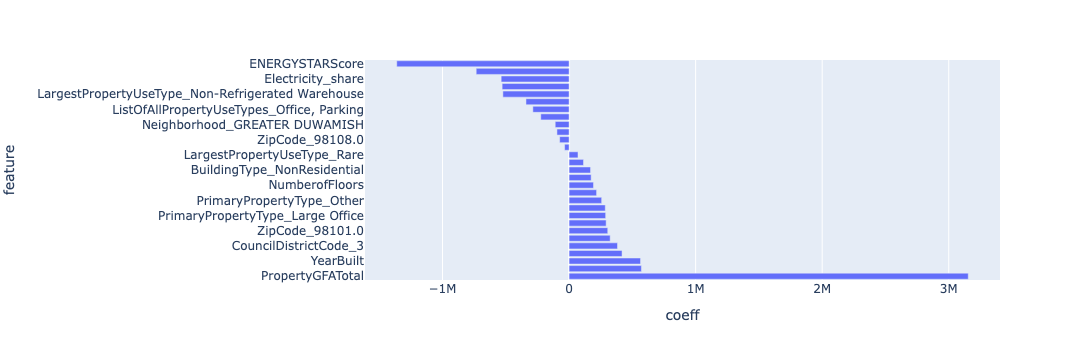

In [184]:
# Coefficient for each feature
df_coeffs = df_coeffs.sort_values(by='coeff', ascending=False)
px.bar(df_coeffs, x='coeff', y='feature', height=len(X_train_lin.columns)*30)

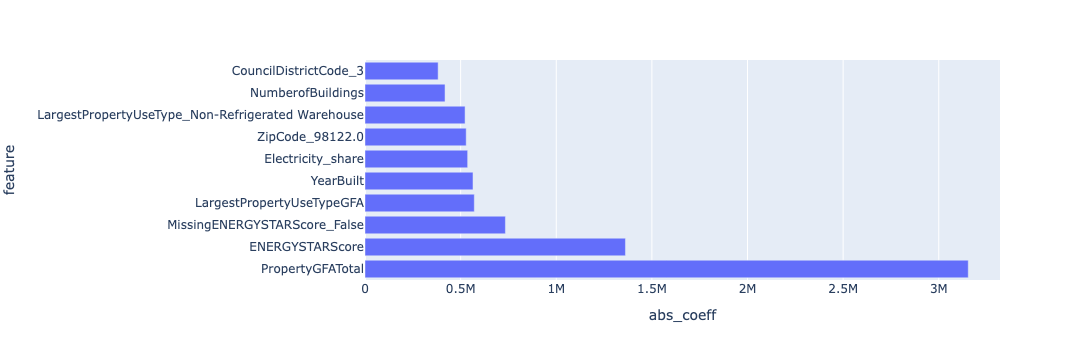

In [185]:
# Top 10 features in absolute coefficient
df_coeffs['abs_coeff'] = abs(df_coeffs.coeff)
df_coeffs = df_coeffs.sort_values(by='abs_coeff', ascending=False)
px.bar(df_coeffs[0:10], x='abs_coeff', y='feature', height=len(X_train.columns)*20)

## <a name="C4">4. Modélisation non linéaire</a>

Les modèles non linéaires sont moins sensibles à la magnitude et à la distribution des features, mais bénéficient d'une dimensionalité réduite.  
Je vais donc les tester sur la matrice de features ne contenant pas ces transformations, et sur celle transformée, pour évaluer l'impact.

J'ai choisi d'utiliser deux modèles non linéaires, un arbre de décision, et une Random Forest.

In [186]:
param_grid = [
    {'model': [DecisionTreeRegressor()]},
    {'model': [RandomForestRegressor()]},
]

In [187]:
pipe = Pipeline(steps=[('model', DummyRegressor())])
grid_search = GridSearchCV(pipe, 
                           param_grid, 
                           cv=5,
                          scoring={
                              'r2': 'r2', 
                              'rmse': 'neg_root_mean_squared_error'
                          },
                           refit='r2'
                          )



In [188]:
# Training on transformed data
grid_search.fit(X_train_lin, y_train_lin)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', DummyRegressor())]),
             param_grid=[{'model': [DecisionTreeRegressor()]},
                         {'model': [RandomForestRegressor()]}],
             refit='r2',
             scoring={'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'})

In [189]:
print_pipeline_results(grid_search)

DecisionTreeRegressor mean R2: 0.03271306346838818 mean RMSE: -6512642.243822928
RandomForestRegressor mean R2: 0.4370411491041808 mean RMSE: -4978742.981787472


In [190]:
# Training on untransformed data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', DummyRegressor())]),
             param_grid=[{'model': [DecisionTreeRegressor()]},
                         {'model': [RandomForestRegressor()]}],
             refit='r2',
             scoring={'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'})

In [191]:
print_pipeline_results(grid_search)

DecisionTreeRegressor mean R2: -0.14193594860733308 mean RMSE: -23726301.00691939
RandomForestRegressor mean R2: 0.5500520072060373 mean RMSE: -18288708.161758754


Il y'a en effet peu de différence entre la performance sur le jeu de données transformé, et le jeu de donné non transformé.  
Le jeu de données transformé sera donc préféré pour sa dimensionalité réduite.

## <a name="C4">5. Modèle final</a>

Le modèle final retenu est la Random Forest, qui apporte les meilleurs résultats sur les métriques de R2 et de RMSE, en étant moins sensible aux outliers.

Grâce à une Randomized Search, on obtient la meilleure combinaison possible de tous les hyperparamètres importants.

In [192]:
X_train = X_train_lin
y_train = y_train_lin
X_test = X_test_lin
y_test = y_test_lin

In [193]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [194]:
regressor = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = regressor, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)


In [195]:
rf_random.fit(X_train, y_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators

KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

In [ ]:
best_rf = rf_random.best_estimator_

Je peux finalement tester mon modèle sur le jeu de test.

In [ ]:
best_rf.fit(X_train_lin, y_train_lin)

In [ ]:
y_pred = best_rf.predict(X_test_lin)
r2 = r2_score(y_test_lin, y_pred) 
rmse = root_mean_squared_error(y_test_lin, y_pred)

In [ ]:
print(r2)
print(rmse)

In [ ]:
tf.lambda_dict_

In [ ]:
df_error = pd.DataFrame({'test': y_test, 'pred': y_pred})
df_error['error'] = df_error.test - df_error.pred
df_error['error_share'] = abs(df_error.error / df_error.test * 100)

In [ ]:
y_test.sort_values()

In [ ]:
df_error.sort_values(by='error_share')

In [ ]:
df_error.error_share.sort_values()

In [ ]:
df_error['binned'] = pd.cut(df_error.error_share, bins=20)
df_error = df_error.sort_values(by='binned')
df_error['binned'] = df_error['binned'].apply(str)

In [ ]:
df_error.binned.value_counts()

In [ ]:
px.histogram(df_error, x='binned')

## <a name="C4">6. Test de l'ENERGY STAR Score</a>

Nous avons déjà pu nous rendre compte à travers l'analyse de l'importance des features des modèles linéaires que l'ENERGY STAR Score était un des prédicteurs les plus importants pour la consommation d'énergie.  
Je vais chercher à confirmer cette observation à travers un A/B Test.

In [ ]:
X_train_minus_star_score = X_train.drop(columns='ENERGYSTARScore')
X_test_minus_star_score = X_test.drop(columns='ENERGYSTARScore')

In [ ]:
best_rf.fit(X_train_minus_star_score, y_train)

In [ ]:
y_pred = best_rf.predict(X_test_minus_star_score)
r2 = r2_score(y_test, y_pred) 
rmse = root_mean_squared_error(y_test, y_pred)

In [ ]:
print(r2)
print(rmse)

Le modèle est en effet moins performant et moins explicatif si l'on retire l'ENERGY STAR Score, mais la différence n'est pas marquée.   
Cette baisse de performance devra être pesée contre la complexité de collection de cette donnée pour décider si cette feature est conservée ou non.

In [ ]:
def invert_yeojhonson(value, lmbda):
  if value>= 0 and lmbda == 0:
    return exp(value) - 1
  elif value >= 0 and lmbda != 0:
    return (value * lmbda + 1) ** (1 / lmbda) - 1
  elif value < 0 and lmbda != 2:
    return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
  elif value < 0 and lmbda == 2:
    return 1 - exp(-value)

In [ ]:
y_pred_i = [invert_yeojhonson(x, 0.15) for x in y_pred]
y_test_i = [invert_yeojhonson(x, 0.15) for x in y_test]

In [ ]:
df_error = pd.DataFrame({'test': y_test_i, 'pred': y_pred_i})
df_error['error'] = df_error.test - df_error.pred
df_error['error_share'] = abs(df_error.error / df_error.test * 100)

In [ ]:
df_error.sort_values(by='error_share')

In [ ]:
df_error.error_share.sort_values()

In [ ]:
bins = list(range(0, 101, 5)) + [float('inf')]
df_error['binned'] = pd.cut(df_error.error_share, bins=bins)
df_error = df_error.sort_values(by='binned')
df_error['binned'] = df_error['binned'].apply(str)

In [ ]:
df_error

In [ ]:
y_df = [invert_yeojhonson(x, 0.1504922) for x in df['SiteEnergyUse(kBtu)']]

In [ ]:
np.mean(y_df)

In [ ]:
df_error.binned.value_counts()

In [ ]:
df_error.error_share.median()

In [ ]:
px.histogram(df_error, x='binned')